<a href="https://colab.research.google.com/github/mtodisco10/fastaiProjects/blob/master/first_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import anvil.server

In [4]:
# Downloading pics to their own folders
path = Path('architecture/buildings')
def download_pics(category_lst):
  for f in category_lst:
    print(f'Downloading {f} images')
    folder = f
    file = f + '.csv'
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    download_images(file, dest, max_pics=200)

category_lst = ['classical','gothic','modern','victorian']
download_pics(category_lst)

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

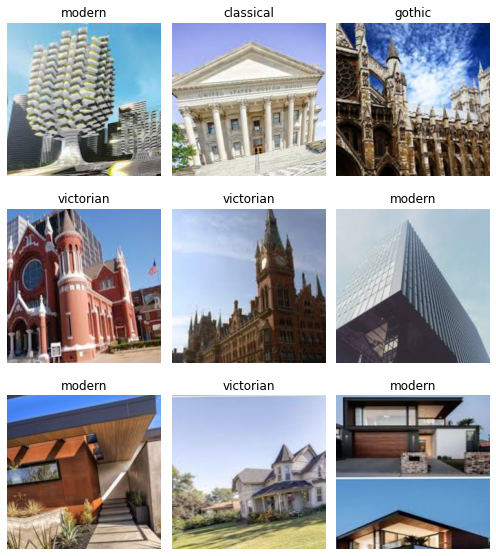

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
classes = ['classical', 'gothic', 'modern', 'victorian']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

classical


gothic


modern


victorian


# Train the Model

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.149160,1.013519,0.409639,00:08
1,1.418782,0.629409,0.240964,00:06
2,1.100091,0.582167,0.204819,00:05
3,0.873227,0.565333,0.192771,00:05


In [10]:
learn.save('stage-1')

In [11]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(6, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.452078,0.551797,0.180723,00:07
1,0.411713,0.551482,0.192771,00:07
2,0.332587,0.546001,0.168675,00:06
3,0.299757,0.547446,0.168675,00:06
4,0.258702,0.560671,0.180723,00:06
5,0.238472,0.557376,0.168675,00:07


In [13]:
interp = ClassificationInterpretation.from_learner(learn)

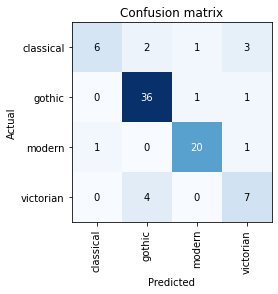

In [14]:
interp.plot_confusion_matrix()

In [15]:
print('This isn\'t too shabby for a first try')
learn.save('stage-2')

This isn't too shabby for a first try


Cleaning the Data

In [16]:
from fastai.widgets import *
db = (ImageList.from_folder(path)
.split_none()
.label_from_folder()
.transform(get_transforms(), size=224)
.databunch())
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [17]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Deploying the Model

In [18]:
learn.export()

In [19]:
defaults.device = torch.device('cpu')

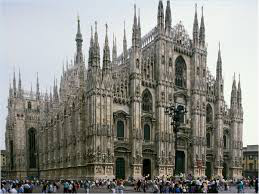

In [20]:
img = open_image(path/'gothic'/'00000000.jpg')
img

In [21]:
learn = load_learner(path)

In [22]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

'gothic'

# Anvil

In [26]:
anvil.server.connect("IZECAG64I62QS23FZUERC7YA-WKCOWPDRCBCCAY6K")

@anvil.server.callable
def classify_architecture(img):
  img = open_image(path/'gothic'/'00000000.jpg')
  pred_class, pred_idx, outputs = learn.predict(img)

  return pred_class

#anvil.server.wait_forever()